In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load Data
url = 'https://raw.githubusercontent.com/akay6483/mmml-ecommerce/refs/heads/main/dataset/online_shoppers_intention.csv'
df = pd.read_csv(url).drop_duplicates()

# Separate features and target
X = df.drop('Revenue', axis=1)
y = df['Revenue']

# Encode Categorical Columns
# Factorize is faster/cleaner for simple ordinal encoding
for col in X.select_dtypes(include=['object', 'bool']).columns:
    X[col] = pd.factorize(X[col])[0]
y = LabelEncoder().fit_transform(y)

# Scale Features
X_scaled = StandardScaler().fit_transform(X)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print(f"Data Processed. Features: {X.shape[1]}, Samples: {X.shape[0]}")

Data Processed. Features: 17, Samples: 12205


Running PCA...
Number of components for 95% variance: 14


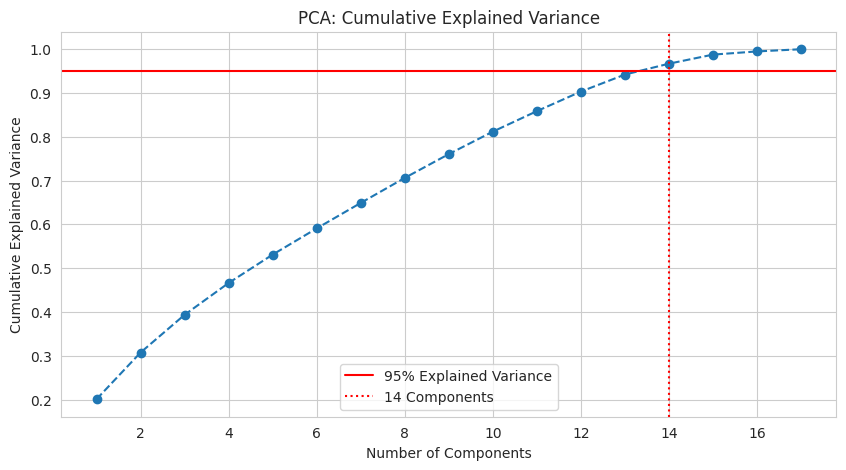

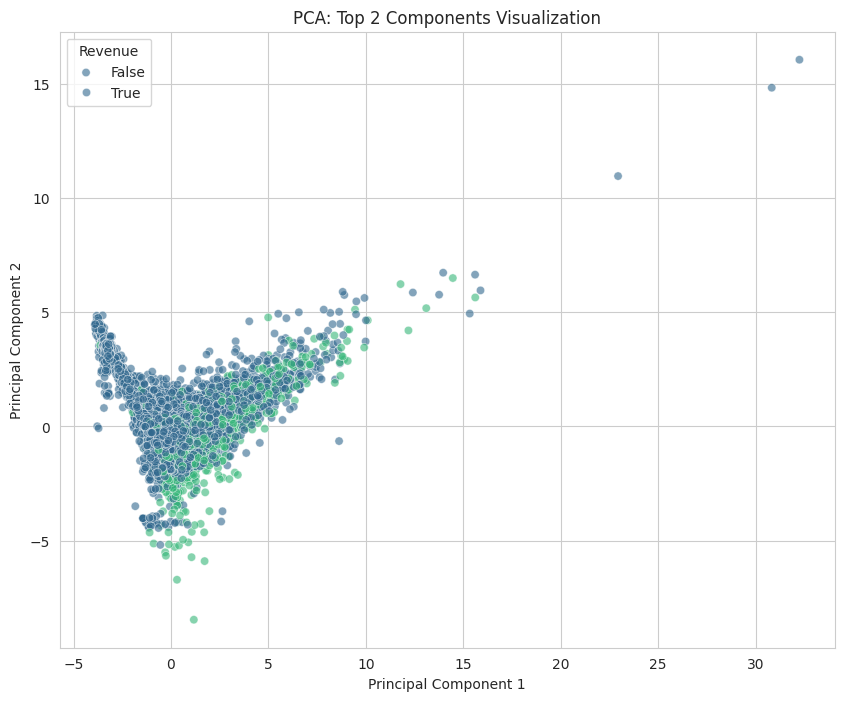

In [3]:
# --- PCA Analysis ---
print("Running PCA...")

# Fit PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate Cumulative Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Number of components for 95% variance: {n_components_95}")

# Plot 1: Cumulative Variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Explained Variance')
plt.axvline(x=n_components_95, color='r', linestyle=':', label=f'{n_components_95} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: 2D Scatter Plot of First 2 Components
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca_2[:, 0], y=X_pca_2[:, 1], hue=y, palette='viridis', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Top 2 Components Visualization')
plt.legend(title='Revenue', labels=['False', 'True'])
plt.show()

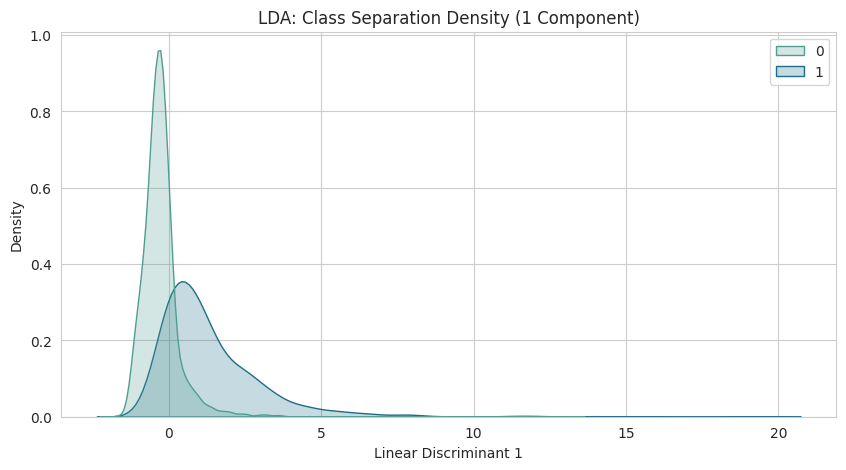

Running Feature Selection...

=== Final Results ===
LDA Accuracy:                         0.8820
Logistic Regression (All 17 Features): 0.8880
Logistic Regression (Top 5 Features):  0.8872
Top 5 Features Selected: ['ExitRates', 'PageValues', 'Browser', 'VisitorType', 'Weekend']


In [4]:
# --- LDA Analysis ---
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_train, y_train)
y_pred_lda = lda.predict(X_test)

# Graph 3: LDA Separation Density
plt.figure(figsize=(10, 5))
sns.kdeplot(x=X_lda.flatten(), hue=y_train, fill=True, palette='crest', common_norm=False)
plt.title('LDA: Class Separation Density (1 Component)')
plt.xlabel('Linear Discriminant 1')
plt.show()

# --- Sequential Feature Selection (SFS) ---
print("Running Feature Selection...")
clf = LogisticRegression(max_iter=1000, random_state=42)
sfs = SequentialFeatureSelector(clf, n_features_to_select=5, direction='forward')
sfs.fit(X_train, y_train)

# Metrics & Results
selected_feats = X.columns[sfs.get_support()].tolist()

# Train/Test on limited feature set
clf.fit(sfs.transform(X_train), y_train)
acc_sfs = accuracy_score(y_test, clf.predict(sfs.transform(X_test)))

# Baseline (All features)
clf.fit(X_train, y_train)
acc_all = accuracy_score(y_test, clf.predict(X_test))

print("\n=== Final Results ===")
print(f"LDA Accuracy:                         {accuracy_score(y_test, y_pred_lda):.4f}")
print(f"Logistic Regression (All 17 Features): {acc_all:.4f}")
print(f"Logistic Regression (Top 5 Features):  {acc_sfs:.4f}")
print(f"Top 5 Features Selected: {selected_feats}")

In [5]:
# --- Sequential Feature Selection ---
print("Running Sequential Feature Selection (this may take a moment)...")

# Define Estimator
model_lr = LogisticRegression(max_iter=1000, random_state=42)

# Initialize SFS (Forward Selection, selecting 5 features)
sfs = SequentialFeatureSelector(model_lr, n_features_to_select=5, direction='forward')
sfs.fit(X_train, y_train)

# Identify Selected Features
selected_indices = sfs.get_support(indices=True)
selected_features = X.columns[selected_indices].tolist()
print(f"Top 5 Selected Features: {selected_features}")

# Evaluate Model with Selected Features vs All Features
# 1. Selected Features
X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)
model_lr.fit(X_train_sfs, y_train)
acc_sfs = accuracy_score(y_test, model_lr.predict(X_test_sfs))

# 2. All Features
model_lr.fit(X_train, y_train)
acc_all = accuracy_score(y_test, model_lr.predict(X_test))

print(f"Accuracy (All 17 Features): {acc_all:.4f}")
print(f"Accuracy (Top 5 Features): {acc_sfs:.4f}")

Running Sequential Feature Selection (this may take a moment)...
Top 5 Selected Features: ['ExitRates', 'PageValues', 'Browser', 'VisitorType', 'Weekend']
Accuracy (All 17 Features): 0.8880
Accuracy (Top 5 Features): 0.8872
